# Polish Crops analysis

With this notebook I would like to playaround some machine learning Python tools. 

Therefore I've decided to create this simple project, in which I want to check a simple hypothesis - is percipitation and/or temperature in Poland affecting prices of crops (soft wheat). In order to achieve it here are the steps:

* **Step 1 Download source reports** - downloading necessary files from publically available databases.

* **Step 2 Data preprocessing** - unnecessary data are removed and prepared for further processing.

* **Step 3 Data visualization** - plotting couple of charts, just to visualize the downloaded data.

* **Step 4 Train machine learning models** - training couple of machine learning regression models to check which one of them fits the best - is it a correlaction between climate (temperature, percipitation) and prices of soft wheat.
---

## Step 1 Download source reports

First you need to download necessary data. They are downloaded from following sources:

* [IMGW (Instytut Meteorologii i Gospodarki Wodnej, *eng.* Polish Institute of Meteorology and Water Management)](https://danepubliczne.imgw.pl)
* [Eurostat](https://ec.europa.eu/eurostat/data/database)


To avoid boilerplate code and to keep this notebook short, inside `./tools` directory there are Python modules that allows to download following reports:

* [Monthly tempreture report in Poland](https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/)
* [Monthly precipitation report in Poland](https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/opad/)
* [Selling prices of crop products (absolute prices) - annual price (from 2000 onwards)](https://ec.europa.eu/eurostat/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=pop_up&p_p_mode=view&p_p_col_id=column-2&p_p_col_pos=1&p_p_col_count=2&_NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ_nodeInfoService=true&nodeId=98243)

Inside reports there are no explanation for every column or for codes inside of some cells, therefore dictionaries file are also need to be downloaded.    

In [2]:
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [3]:
import tools.imgw as imgw
import tools.eurostat as eurostat

raw_temperature_report_paths = imgw.download_temperature_reports(years)
temperature_report_dic_path = imgw.download_temperature_report_dic()

raw_precipitation_report_paths = imgw.download_precipitation_reports(years)
precipitation_report_dic_path = imgw.download_precipitation_report_dic()

raw_crop_prices_report_path = eurostat.download_crop_prices()
crop_categories_dic_path = eurostat.download_crop_categories_dic()

## Step 2 Data preprocessing

Before training machine learning models or plotting charts, data needs to be prepared. 

### Step 2.1 Prepare temperature data

All temperature report files doesn't have column headers, therefore to check what each one of them mean we need to examin `k_m_t_format.txt` file. Here is a code that prints the headers (unfortunately in polish, I'll translate them in next step)

In [17]:
f = open(temperature_report_dic_path)
index = -1
for line in f:
    print('{}\t{}'.format(index,line))
    index += 1
f.close()

-1	

0	Kod stacji                                       9

1	Nazwa stacji                                    30

2	Rok                                              4

3	Miesiąc                                          2

4	Średnia miesięczna temperatura [°C]              5/1

5	Status pomiaru TEMP                              1

6	Średnia miesięczna wilgotność względna [%]       8/1

7	Status pomiaru WLGS                              1

8	Średnia miesięczna prędkość wiatru [m/s]         6/1

9	Status pomiaru FWS                               1

10	Średnie miesięczne zachmurzenie ogólne [oktanty] 6/1

11	Status pomiaru NOS                               1

12	   

13	Status "8" brak pomiaru


In previous step, we've downloaded one file per each year, which now needs to combined into single one. Moreover, each of these files has temperature readings for several places across Poland. I've decided to calculate an average temperature for each month for entire Poland.

In [18]:
import pandas as pd

temperature_data_path = 'data/processed/temperature.csv'

for i in range(len(years)):
    df = pd.read_csv(raw_temperature_report_paths.get(years[i]), header = None, encoding= 'unicode_escape')
    df = df.drop(columns=[0, 1, 5, 6, 7, 8, 9, 10, 11])
    df = df.rename(columns={2: 'Year', 3: 'Month', 4: 'Temperature [°C]'})

    # combine two columns into one in date_time format
    df['Date'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y').dt.strftime('%m-%Y')
    df = df.groupby('Date', as_index=False).mean()


    if i == 0:
        df.to_csv(temperature_data_path, mode = 'a')
    else:    
        df.to_csv(temperature_data_path, mode = 'a', header = False)
df.head(5) # just for printing, to show the result

,Date,Year,Month,Temperature [°C]
0,01-2018,2018,1,0.235211
1,02-2018,2018,2,-4.318310
2,03-2018,2018,3,-0.677465
3,04-2018,2018,4,11.971831
4,05-2018,2018,5,15.518310


### Step 2.2 Prepare precipitation data

Same story is with precipitation, first list of columns headers.

In [6]:
f = open(precipitation_report_dic_path)
index = -1
for line in f:
    print('{}\t{}'.format(index,line))
    index += 1
f.close()

-1	

0	Kod stacji                                        9

1	Nazwa stacji                                     30

2	Rok                                               4

3	Miesiąc                                           2

4	Miesięczna suma opadów [mm]                       8/1

5	Status pomiaru SUMM                               1

6	Liczba dni z opadem śniegu                        5

7	Status pomiaru LDS                                1

8	Opad maksymalny [mm]                              8/1

9	Status pomiaru MAXO                               1

10	Dzień pierwszy wystąpienia opadu maksymalnego     2

11	Dzień ostatni wystąpienia opadu maksymalnego      2

12	Liczba dni z pokrywą śnieżną                      5

13	Status pomiaru LDPS                               1

14	

15	Status "8" brak pomiaru

16	Status "9" brak zjawiska


Next, precipitation data are prepared in similar manner as it was for temperatures. 

In [19]:
precipitation_data_path = 'data/processed/precipitation.csv'

for i in range(len(years)):
    df = pd.read_csv(raw_precipitation_report_paths.get(years[i]), header = None, encoding= 'unicode_escape')
    df = df.drop(columns=[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    df = df.rename(columns={2: 'Year', 3: 'Month', 4: 'Precipitation [mm]'})
    df['Date'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y').dt.strftime('%m-%Y')
    df = df.groupby('Date', as_index=False).mean()
    if i == 0:
        df.to_csv(precipitation_data_path, mode = 'a')
    else:    
        df.to_csv(precipitation_data_path, mode = 'a', header = False)
df.head(5) # just for printing, to show the result

,Date,Year,Month,Precipitation [mm]
0,01-2018,2018,1,45.995622
1,02-2018,2018,2,14.471329
2,03-2018,2018,3,31.855769
3,04-2018,2018,4,30.442483
4,05-2018,2018,5,51.478846


### Step 2.3 Prepare crop prices data

As crop prices data are taken from different source, they look a little bit different. Downloaded report (`apri_ap_crpouta.tsv`) contains headers, but in *product category* column there is provided a code, which is not a descriptive name, therefore like before a dictionary file has been downloaded with full description for each code.

In [8]:
f = open(crop_categories_dic_path)
index = 0
for line in f:
    print('{}\t{}'.format(index,line))
    index += 1
f.close()

0	01110000	Soft wheat - prices per 100 kg

1	01120000	Durum wheat - prices per 100 kg

2	01200000	Rye - prices per 100 kg

3	01300000	Barley - prices per 100 kg

4	01310000	Feed barley - prices per 100 kg

5	01320000	Malting barley - prices per 100 kg

6	01400000	Oats - prices per 100 kg

7	01500000	Maize - prices per 100 kg

8	01600000	Rice - prices per 100 kg

9	01910000	Sorghum - prices per 100 kg

10	01920000	Triticale - prices per 100 kg

11	02110000	Rape - prices per 100 kg

12	02120000	Sunflowers - prices per 100 kg

13	02130000	Soya - prices per 100 kg

14	02210000	Dried peas - prices per 100 kg

15	02220000	Dried beans - prices per 100 kg

16	02230000	Broad beans (dry) - prices per 100 kg

17	02300000	Raw tobacco: all varieties - prices per 100 kg

18	02400000	Sugar beet: unit value - prices per 1000 kg

19	02911000	Cotton (including seed) - prices per 100 kg

20	02920000	Hops : all varieties - prices per 100 kg

21	02991000	Lentils - prices per 100 kg

22	02992000	Chick peas 

We're interested in the `01110000	Soft wheat - prices per 100 kg` product category. Here is the code for data preparation. 

In [20]:
crops_data_path = 'data/processed/crops.csv'

df = pd.read_csv(raw_crop_prices_report_path, sep = '\t')

# splitting one column into three by ',' 
df = pd.concat([df['currency,prod_veg,geo\\time'].str.split(',', expand=True), df], axis=1)
df = df.rename(columns={0: 'Currency', 1: 'Product category code', 2: 'Country'})

df = df[(df['Product category code'] == '01110000') & (df['Country'] == 'PL') & (df['Currency'] == 'EUR')]
df = df.drop(columns=['Currency', 'Product category code', 'Country', 'currency,prod_veg,geo\\time'])

# transpose data and reset indexes
df = df.transpose()
df['Year'] = df.index
df = df.rename(columns={19: 'Soft wheat prices [EUR per 100 kg]'})
df = df[['Year', 'Soft wheat prices [EUR per 100 kg]']]
df = df.sort_values(by=['Year'])
df.reset_index(drop=True, inplace=True)
df.to_csv(crops_data_path)

df.head(5) # just for printing, to show the result

,Year,Soft wheat prices [EUR per 100 kg]
0,2000,12.68
1,2001,13.74
2,2002,11.31
3,2003,10.34
4,2004,10.42


## Step 3 Data visualization

Data are now prepared and stored in `data/processed` folder. So now it's time visualize them on charts.

### Step 3.1 Average monthly temperatures in Poland chart

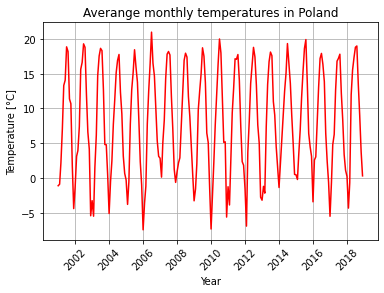

In [37]:
import matplotlib.pyplot as plt
import datetime

temperature_df = pd.read_csv(temperature_data_path)
x = [datetime.datetime.strptime(date, '%m-%Y') for date in temperature_df['Date']]
plt.plot(x, temperature_df['Temperature [°C]'], color='red')

plt.title('Average monthly temperatures in Poland')
plt.ylabel('Temperature [°C]')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 3.2 Average monthly precipitation in Poland

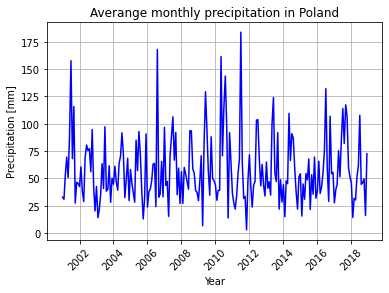

In [39]:
precipitation_df = pd.read_csv(precipitation_data_path)
x = [datetime.datetime.strptime(date, '%m-%Y') for date in precipitation_df['Date']]
plt.plot(x, precipitation_df['Precipitation [mm]'], color='blue')

plt.title('Average monthly precipitation in Poland')
plt.ylabel('Precipitation [mm]')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 3.3 Annual selling prices of soft wheat in Poland

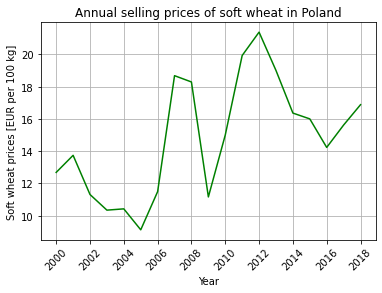

In [45]:
crops_df = pd.read_csv(crops_data_path)
x = [datetime.datetime(year, 1, 1) for year in crops_df['Year']]
plt.plot(x, crops_df['Soft wheat prices [EUR per 100 kg]'], color='green')

plt.title('Annual selling prices of soft wheat in Poland')
plt.ylabel('Soft wheat prices [EUR per 100 kg]')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Step 4 Train machine learning models